In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
pdf = pd.read_csv("pull_requests.csv", parse_dates=['created_at', 'closed_at', 'merged_at'])

/home/hannah/miniconda3/envs/mpl/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (77,99) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
pdf.columns

Index(['url', 'id', 'node_id', 'html_url', 'diff_url', 'patch_url',
       'issue_url', 'number', 'state', 'locked',
       ...
       'assignee.received_events_url', 'assignee.type', 'assignee.site_admin',
       'head.repo', 'head.repo.license.key', 'head.repo.license.name',
       'head.repo.license.spdx_id', 'head.repo.license.url',
       'head.repo.license.node_id', 'head.user'],
      dtype='object', length=335)

https://developer.github.com/v3/pulls/#list-pull-requests
* "state": "open",
* "created_at": "2011-01-26T19:01:12Z",
* "closed_at": "2011-01-26T19:01:12Z",
* "merged_at": "2011-01-26T19:01:12Z",

In [5]:
psub = pdf[['user.login', 'id', 'state', 'created_at', 'closed_at', 'merged_at', 'author_association']].copy()

In [6]:
psub.drop(labels=7701, inplace=True) # negative close rate

In [7]:
psub.columns

Index(['user.login', 'id', 'state', 'created_at', 'closed_at', 'merged_at',
       'author_association'],
      dtype='object')

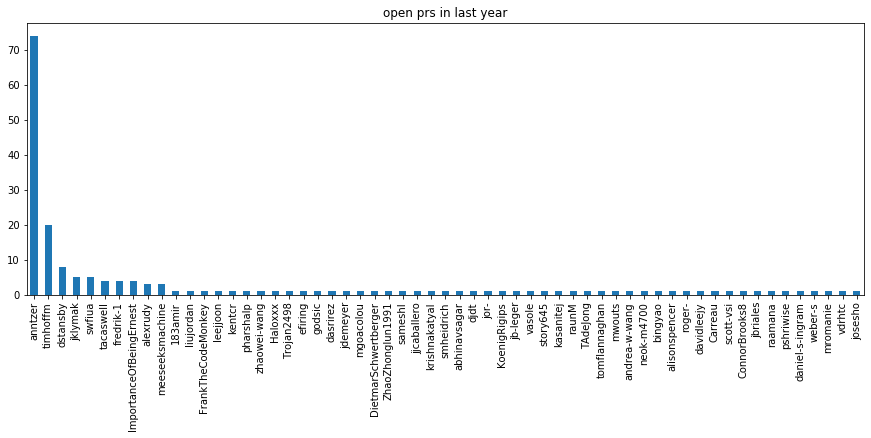

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title("open prs in last year")
_ = psub[(psub['created_at']>'2018-07-17') & 
         psub['state'].str.match('open')]['user.login'].value_counts().plot.bar(ax=ax)

In [9]:
#drop bot
psub = psub[~psub['user.login'].str.match('meeseeksmachine')]

In [10]:
psub['merge_rate'] = psub['merged_at'] - psub['created_at']
psub['close_rate'] = psub['closed_at'] - psub['created_at']

In [11]:
# blank out the close without merging
psub['close_wno_merge_rate'] = psub['close_rate']
psub['close_wno_merge_rate'] = psub['close_rate'].where(psub['merge_rate'].isnull(), pd.NaT, )

In [12]:
psub[['merge_rate', 'close_rate', 'close_wno_merge_rate']].describe()

,merge_rate,close_rate,close_wno_merge_rate
count,6937,8233,1296
mean,15 days 22:07:28.792129,37 days 17:31:25.677274,154 days 11:04:33.095679
std,57 days 13:10:23.177546,140 days 23:25:45.074302,303 days 23:53:38.503900
min,0 days 00:00:05,0 days 00:00:05,0 days 00:00:05
25%,0 days 06:03:15,0 days 06:36:50,0 days 18:09:52
50%,1 days 06:11:17,1 days 15:39:59,11 days 19:26:05.500000
75%,7 days 07:29:37,10 days 20:12:11,143 days 01:31:16.500000
max,1172 days 02:46:16,2003 days 08:13:21,2003 days 08:13:21


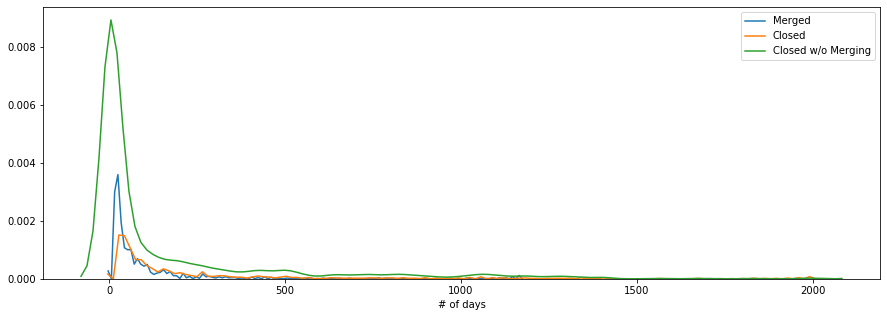

In [13]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,5))
_ = sns.distplot(psub['merge_rate'].dropna(how='all').dt.days, ax=ax, hist=False, label="Merged")
_ = sns.distplot(psub['close_rate'].dropna(how='all').dt.days, ax=ax, hist=False, label="Closed")
_ = sns.distplot(psub['close_wno_merge_rate'].dropna(how='all').dt.days, ax=ax, 
                 hist=False, label='Closed w/o Merging')
_ = ax.legend()
_ = ax.set_xlabel("# of days")

In [15]:
p2019 = psub[psub['created_at']>'2018-07-1'].copy()

In [16]:
ppr = p2019.groupby([pd.Grouper(key='created_at', freq='m'), 'state']).count()

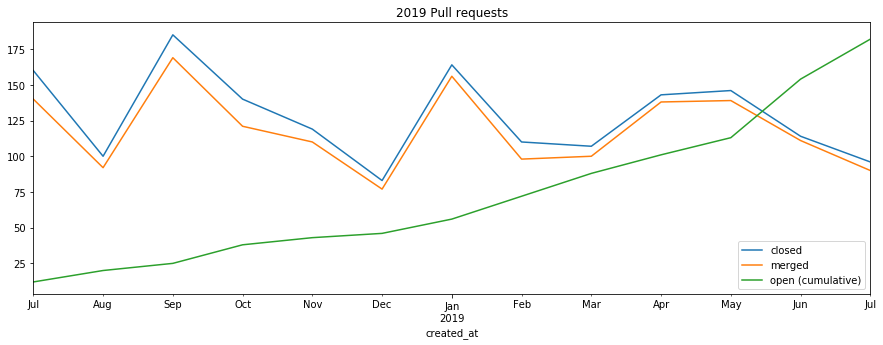

In [29]:
fig, ax = plt.subplots(figsize=(15,5))
_ = ax.set_title("2019 Pull requests")
_ = ppr['closed_at'].unstack()['closed'].plot(ax=ax, label='closed')
_ = ppr['merged_at'].unstack()['closed'].plot(ax=ax, label='merged')
_ = ppr['user.login'].unstack()['open'].cumsum().plot(ax=ax, label='open (cumulative)') 
_ = ax.legend()

In [30]:
pre2019 = psub[(psub['created_at']<='2018-07-1') & psub['state'].str.match('open')]['state'].count()

In [32]:
opened = p2019.groupby(pd.Grouper(key='created_at', freq='M'))['created_at'].count()

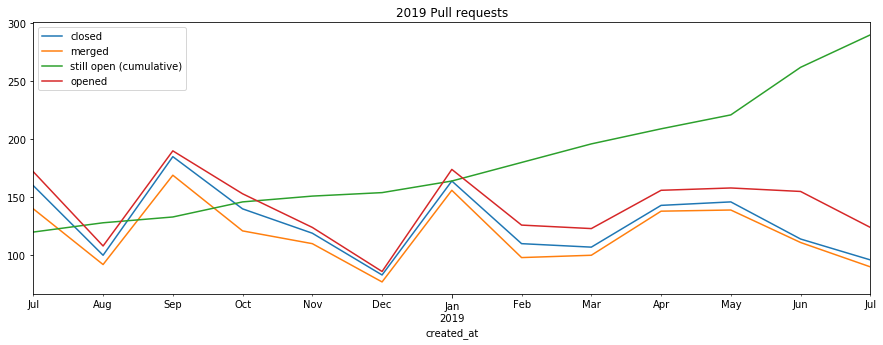

In [35]:
fig, ax = plt.subplots(figsize=(15,5))
_ = ax.set_title("2019 Pull requests")
_ = ppr['closed_at'].unstack()['closed'].plot(ax=ax, label='closed')
_ = ppr['merged_at'].unstack()['closed'].plot(ax=ax, label='merged')
_ = (ppr['user.login'].unstack()['open'].cumsum() + pre2019).plot(ax=ax, label='still open (cumulative)')
_ = opened.plot(ax=ax, label='opened')
    
_ = ax.legend()

In [36]:
psub.columns

Index(['user.login', 'id', 'state', 'created_at', 'closed_at', 'merged_at',
       'author_association', 'merge_rate', 'close_rate',
       'close_wno_merge_rate'],
      dtype='object')

In [38]:
pdr = psub.groupby([pd.Grouper(key='created_at', freq='m'), 'state']).count()
all_opened = psub.groupby(pd.Grouper(key='created_at', freq='m'))['created_at'].count()

/home/hannah/miniconda3/envs/mpl/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


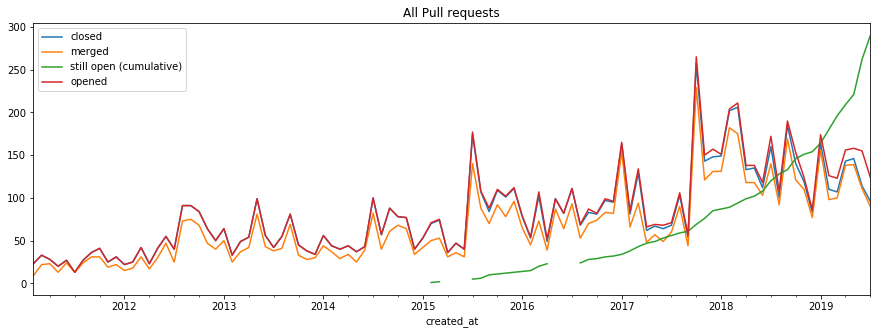

In [39]:
fig, ax = plt.subplots(figsize=(15,5))
_ = ax.set_title("All Pull requests")
_ = pdr['closed_at'].unstack()['closed'].plot(ax=ax, label='closed')
_ = pdr['merged_at'].unstack()['closed'].plot(ax=ax, label='merged')
_ = pdr['user.login'].unstack()['open'].cumsum().plot(ax=ax, label='still open (cumulative)') 
_ = all_opened.plot(label = "opened")
_ = ax.legend()

In [40]:
pdf[pdf['user.login'].str.match('meeseeksmachine')][['created_at','closed_at', 'merged_at']].count()

created_at    526
closed_at     523
merged_at     515
dtype: int64

In [41]:
523/526, 515/526

(0.9942965779467681, 0.9790874524714829)

/home/hannah/miniconda3/envs/mpl/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


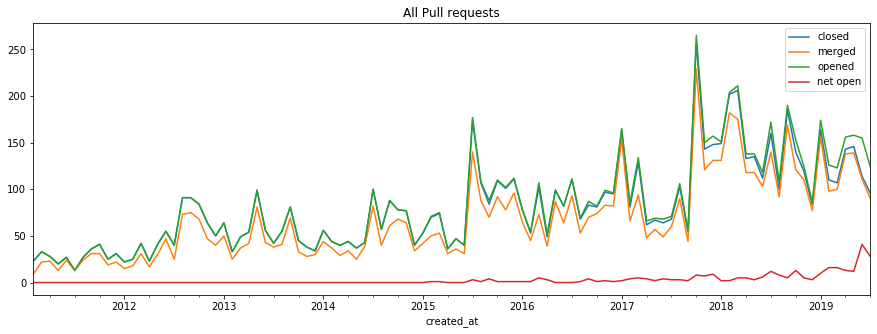

In [45]:
fig, ax = plt.subplots(figsize=(15,5))
_ = ax.set_title("All Pull requests")
_ = pdr['closed_at'].unstack()['closed'].plot(ax=ax, label='closed')
_ = pdr['merged_at'].unstack()['closed'].plot(ax=ax, label='merged')
#_ = pdr['created_at'].unstack()['open'].cumsum().plot(ax=ax, label='still open (cumulative)') 
_ = all_opened.plot(label = "opened")
_ = (all_opened-pdr['closed_at'].unstack()['closed']).plot(ax=ax, label='net open')
_ = ax.set_label("# PRs")
_ = ax.legend()

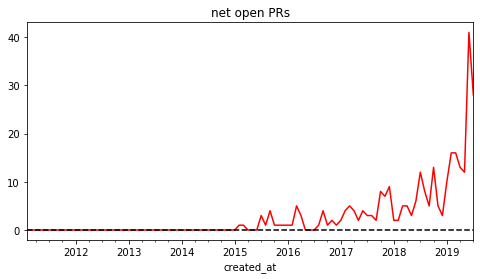

In [46]:
fig, ax = plt.subplots(figsize=(8,4))
_ = ax.set_title("net open PRs")
_ = (all_opened-pdr['closed_at'].unstack()['closed']).plot(ax=ax, label='net open', color='red')
_ = ax.axhline(y=0, color='black', linestyle='--')

# Anthony Effect

In [47]:
psub[psub['state'].str.match('open')]['user.login'].value_counts()['anntzer']

85

In [48]:
psub[psub['state'].str.match('open')]['user.login'].value_counts().sum()

290

In [49]:
85/290

0.29310344827586204

In [50]:
pna = psub[psub['user.login'].str.match('anntzer')]

In [52]:
pga = pna.groupby(pd.Grouper(key='created_at', freq='M')).count()

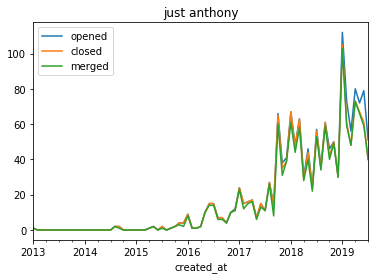

In [61]:
fig, ax = plt.subplots()
ax.set_title("just anthony")
pga[['user.login', 'closed_at', 'merged_at']].plot(ax=ax)
ax.legend(['opened', "closed", "merged"])

In [58]:
pnoa = psub[~psub['user.login'].str.match('anntzer')]
pnga = pnoa.groupby(pd.Grouper(key='created_at', freq='M')).count() 

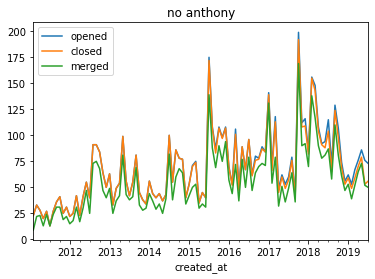

In [62]:
fig, ax = plt.subplots()
ax.set_title("no anthony")
pnga[['user.login', 'closed_at', 'merged_at']].plot(ax=ax)
ax.legend(['opened', "closed", "merged"])

In [63]:
pnga['user'] = 'everyone else'
pga['user'] = 'anthony'

In [64]:
pgg = pd.concat([pnga, pga])

In [66]:
# count anthony, everyone else
ant = pgg.reset_index().groupby([pd.Grouper(key='created_at', freq='m'),'user']).sum().unstack().fillna(0)

In [67]:
ant.head()

user.login                    id                \
user                         anthony everyone else anthony everyone else   
created_at                                                                 
2011-02-28 00:00:00+00:00        0.0          23.0     0.0          23.0   
2011-03-31 00:00:00+00:00        0.0          33.0     0.0          33.0   
2011-04-30 00:00:00+00:00        0.0          28.0     0.0          28.0   
2011-05-31 00:00:00+00:00        0.0          20.0     0.0          20.0   
2011-06-30 00:00:00+00:00        0.0          27.0     0.0          27.0   

                            state               closed_at                \
user                      anthony everyone else   anthony everyone else   
created_at                                                                
2011-02-28 00:00:00+00:00     0.0          23.0       0.0          23.0   
2011-03-31 00:00:00+00:00     0.0          33.0       0.0          33.0   
2011-04-30 00:00:00+00:00     0.0          28.0       0.0          28.0   
2011-05-31 00:00:00+00:00     0.0          20.0       0.0          20.0   
2011-06-30 00:00:00+00:00     0.0          27.0       0.0          27.0   

                          merged_at               author_association  \
user                        anthony everyone else            anthony   
created_at                                                             
2011-02-28 00:00:00+00:00       0.0           9.0                0.0   
2011-03-31 00:00:00+00:00       0.0          22.0                0.0   
2011-04-30 00:00:00+00:00       0.0          23.0                0.0   
2011-05-31 00:00:00+00:00       0.0          13.0                0.0   
2011-06-30 00:00:00+00:00       0.0          24.0                0.0   

                                        merge_rate               close_rate  \
user                      everyone else    anthony everyone else    anthony   
created_at                                                                    
2011-02-28 00:00:00+00:00          23.0        0.0           9.0        0.0   
2011-03-31 00:00:00+00:00          33.0        0.0          22.0        0.0   
2011-04-30 00:00:00+00:00          28.0        0.0          23.0        0.0   
2011-05-31 00:00:00+00:00          20.0        0.0          13.0        0.0   
2011-06-30 00:00:00+00:00          27.0        0.0          24.0        0.0   

                                        close_wno_merge_rate                
user                      everyone else              anthony everyone else  
created_at                                                                  
2011-02-28 00:00:00+00:00          23.0                  0.0          14.0  
2011-03-31 00:00:00+00:00          33.0                  0.0          11.0  
2011-04-30 00:00:00+00:00          28.0                  0.0           5.0  
2011-05-31 00:00:00+00:00          20.0                  0.0           7.0  
2011-06-30 00:00:00+00:00          27.0                  0.0           3.0

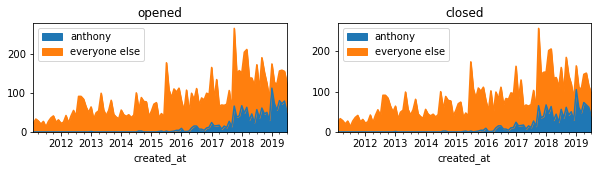

In [69]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,2))
_ = ax1.set_title("opened")
_ = ant['user.login'].plot.area(ax=ax1)
_ = ax1.legend()
_ = ax2.set_title("closed")
_ = ant['closed_at'].plot.area(ax=ax2)
_ = ax2.legend()

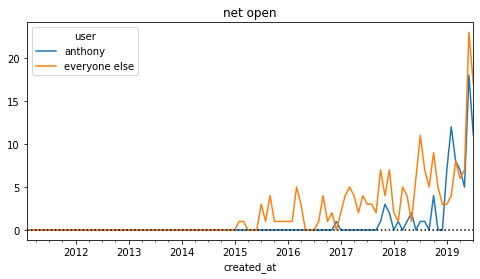

In [71]:
#group nets:
fig, ax = plt.subplots(figsize=(8,4))
ax.set_title('net open')
_ = (ant['user.login']-ant['closed_at']).plot(ax=ax)
_ = ax.axhline(0, color='k', linestyle=":")

# contributor type

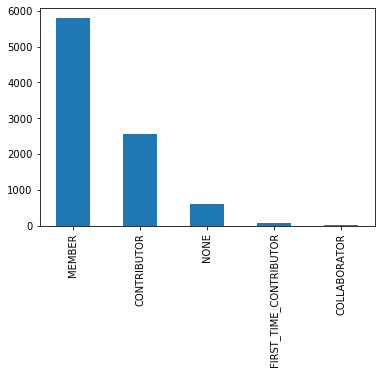

In [72]:
pdf['author_association'].value_counts().plot.bar()

In [73]:
nobot = pdf[~pdf['user.login'].str.match('meeseeksmachine')]

In [76]:
psub.groupby('author_association')[['merge_rate','close_rate', 'close_wno_merge_rate']].describe().T

author_association                       COLLABORATOR  \
merge_rate           count                         19   
                     mean      6 days 18:32:14.263157   
                     std       6 days 23:39:46.248270   
                     min              0 days 00:03:47   
                     25%              1 days 21:37:18   
                     50%              3 days 17:28:02   
                     75%      12 days 02:51:05.500000   
                     max             20 days 12:01:03   
close_rate           count                         21   
                     mean    101 days 18:02:45.428571   
                     std     435 days 18:14:05.263673   
                     min              0 days 00:03:47   
                     25%              2 days 01:55:33   
                     50%              4 days 18:32:01   
                     75%             13 days 05:17:40   
                     max           2003 days 08:13:21   
close_wno_merge_rate count                          2   
                     mean          1004 days 01:22:41   
                     std    1413 days 04:51:49.959423   
                     min              4 days 18:32:01   
                     25%            504 days 09:57:21   
                     50%           1004 days 01:22:41   
                     75%           1503 days 16:48:01   
                     max           2003 days 08:13:21   

author_association                       CONTRIBUTOR  \
merge_rate           count                      1596   
                     mean    20 days 22:04:06.270676   
                     std     75 days 01:21:46.382544   
                     min             0 days 00:01:10   
                     25%      0 days 06:42:31.250000   
                     50%      1 days 17:27:29.500000   
                     75%             9 days 02:51:02   
                     max          1172 days 02:46:16   
close_rate           count                      1985   
                     mean    46 days 02:43:20.074559   
                     std    159 days 11:52:28.438642   
                     min             0 days 00:00:07   
                     25%             0 days 07:09:33   
                     50%             2 days 02:08:47   
                     75%            14 days 08:43:20   
                     max          1985 days 15:06:06   
close_wno_merge_rate count                       389   
                     mean   149 days 11:30:45.840616   
                     std    305 days 22:26:27.284078   
                     min             0 days 00:00:07   
                     25%             0 days 11:57:42   
                     50%             9 days 20:17:22   
                     75%           130 days 06:31:31   
                     max          1985 days 15:06:06   

author_association            FIRST_TIME_CONTRIBUTOR  \
merge_rate           count                         1   
                     mean            5 days 01:18:20   
                     std                         NaT   
                     min             5 days 01:18:20   
                     25%             5 days 01:18:20   
                     50%             5 days 01:18:20   
                     75%             5 days 01:18:20   
                     max             5 days 01:18:20   
close_rate           count                        16   
                     mean    73 days 21:02:59.187500   
                     std    204 days 22:55:42.594135   
                     min             0 days 00:00:28   
                     25%      0 days 03:55:27.500000   
                     50%             5 days 08:34:31   
                     75%     32 days 03:40:29.500000   
                     max           825 days 15:40:00   
close_wno_merge_rate count                        15   
                     mean    78 days 11:09:57.800000   
                     std    211 days 07:07:14.736282   
                     min             0 days 00:00:28 

In [77]:
atype = psub[['author_association','merge_rate', 'close_rate', 'close_wno_merge_rate']].melt(id_vars='author_association',
     value_vars=['merge_rate', 'close_rate', 'close_wno_merge_rate'])
atype['days'] = atype['value'].dt.days

In [78]:
atype.head()

,author_association,variable,value,days
0,MEMBER,merge_rate,NaT,NaN
1,MEMBER,merge_rate,NaT,NaN
2,MEMBER,merge_rate,1 days 16:01:58,1.0
3,CONTRIBUTOR,merge_rate,0 days 05:20:50,0.0
4,MEMBER,merge_rate,NaT,NaN


In [79]:
import seaborn

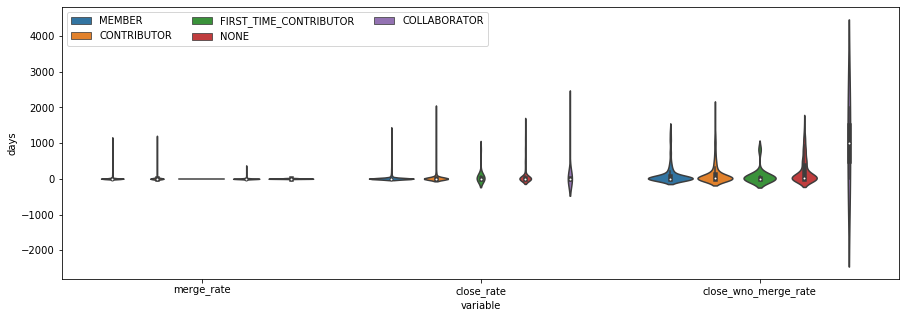

In [80]:
fig, ax = plt.subplots(figsize=(15,5))
_ = sns.violinplot(x='variable', y ='days', hue='author_association', data=atype, ax=ax)
_ = ax.legend(ncol=3, loc='upper left')

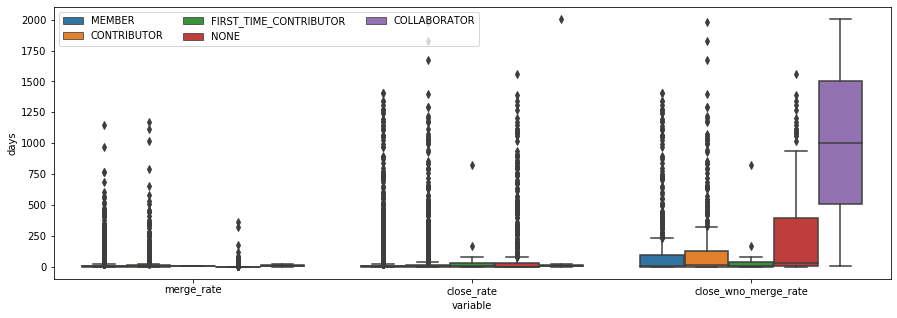

In [81]:
fig, ax = plt.subplots(figsize=(15,5))
_ = sns.boxplot(x='variable', y ='days', hue='author_association', data=atype, ax=ax)
_ = ax.legend(ncol=3, loc='upper left')

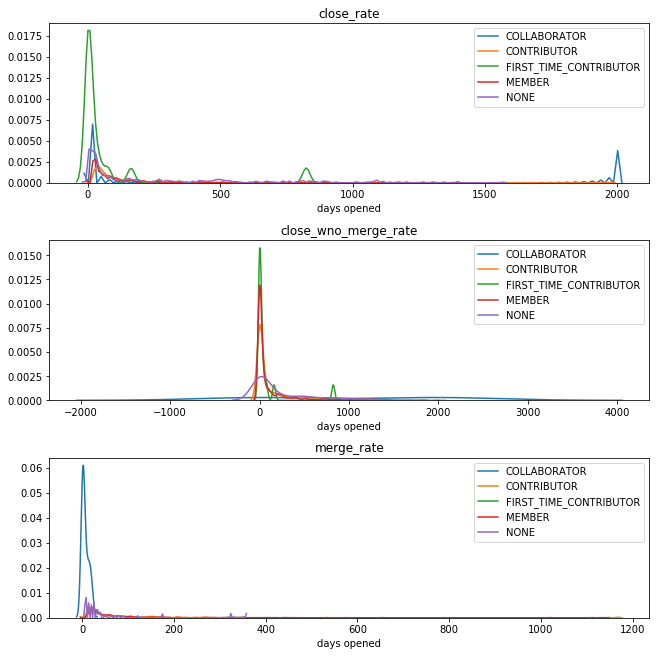

In [105]:
fig, axes = plt.subplots(nrows=3,figsize=(9,9), constrained_layout=True)
for ax, (var, dfg) in zip(axes, atype.groupby('variable')):
    ax.set_title(f'{var}')
    for group, dfga in dfg.groupby('author_association'):
        sns.distplot(dfga['days'], hist=False, label=group, ax=ax)
    ax.set_xlabel("days opened")
    

Index(['author_association', 'variable', 'value', 'days'], dtype='object')

Text(15.950000000000003, 0.5, 'Closed PRs (count)')

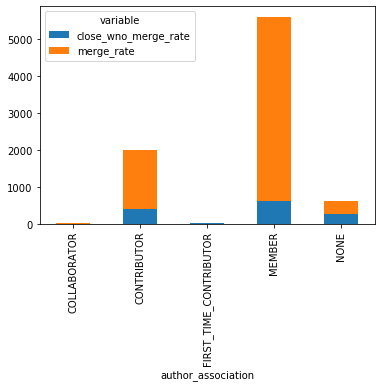

In [112]:
ag = atype.groupby(['author_association','variable']).count()['value'].unstack()
ag[['close_wno_merge_rate', 'merge_rate']].plot.bar(stacked='true')
ax.legend(["merged", "closed"])
ax.set_ylabel("Closed PRs (count)")

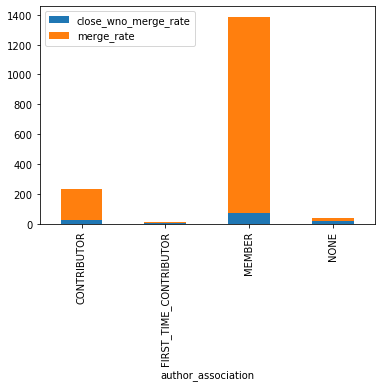

In [118]:
psub[psub['created_at']>'2018-07'].groupby('author_association').count()[['close_wno_merge_rate', 'merge_rate']].plot.bar(stacked='true')